In [25]:
import os

import torch
import torch.distributed as dist
import torch.multiprocessing as mp
from torchviz import make_dot

https://discuss.pytorch.org/t/clone-and-detach-in-v0-4-0/16861

## Detach

`tensor.detach()` creates a tensor that shares storage with tensor that does not require grad.

$$x = 1$$
$$y = x^2$$
$$z = x^3$$
$$r = y + z$$

In [2]:
x = torch.ones(1, requires_grad=True)
y = x**2
z = x**3
r = (y+z)

In [3]:
x_ = torch.ones(1, requires_grad=True)
y_ = x_.detach()**2
z_ = x_**3
r_ = (y_+z_)

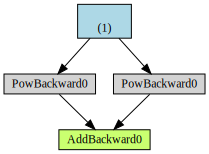

In [4]:
make_dot(r)

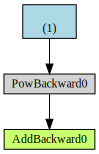

In [5]:
make_dot(r_)

In [6]:
r.backward()
x.grad

tensor([5.])

In [7]:
r_.backward()
x_.grad

tensor([3.])

## Clone

`tensor.clone()` creates a copy of tensor that imitates the original tensor's requires_grad field.

$$x = 1$$
$$y = x^2$$
$$z = x^3$$
$$r = y + z$$

In [8]:
x = torch.ones(1, requires_grad=True)
y = x**2
z = x**3
r = (y+z)

In [9]:
x_ = torch.ones(1, requires_grad=True)
y_ = x_.clone()**2
z_ = x_**3
r_ = (y_+z_)

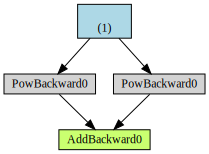

In [10]:
make_dot(r)

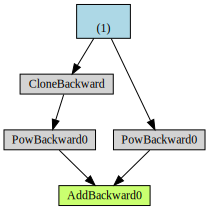

In [11]:
make_dot(r_)

In [12]:
r.backward()
x.grad

tensor([5.])

In [13]:
r_.backward()
x_.grad

tensor([5.])

In [14]:
a = torch.rand(1, requires_grad=True)
print("a: {}".format(a))
a_ = a.clone()
print("a.clone(): {}".format(a_))
print("ID of a: {}".format(id(a)))
print("ID of a.clone(): {}".format(id(a_)))

a: tensor([0.7199], requires_grad=True)
a.clone(): tensor([0.7199], grad_fn=<CloneBackward>)
ID of a: 140271699081408
ID of a.clone(): 140271699052576


## torch.distributed API

Following is a simple toy example that uses the `torch.distributed` API. It collects simulated (random) data from different processes to the master process using `dist.reduce` and calculates the average.

In [68]:
def init_process(rank, world_size, fn, backend='gloo'):
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "61820"
    dist.init_process_group(backend, rank=rank, world_size=world_size)
    torch.seed()
    fn(rank, world_size)

def fn(rank, world_size):
    group = dist.new_group(list(range(world_size)))
    tensor = torch.rand(1)
    print("Rank", rank, "-", tensor[0])
    dist.reduce(tensor, dst=0, op=dist.ReduceOp.SUM, group=group)
    if rank == 0:
        tensor /= 4
        print("\nRank", rank, "has average:", tensor[0])

In [69]:
world_size = 4
processes = []

for rank in range(world_size):
    p = mp.Process(target=init_process, args=(rank, world_size, fn))
    p.start()
    processes.append(p)
for p in processes:
    p.join()

Rank 0 - tensor(0.5188)
Rank 1 - tensor(0.6710)
Rank 3 - tensor(0.6057)
Rank 2 - tensor(0.0005)

Rank 0 has average: tensor(0.4490)
